# 0. Introduction

The website Metacritic.com aggregates critics reviews across various forms of media, among which video games. In addition to reporting a score if applicable, Metacritic tries to summarize a review by quoting parts of it. The goal of this project is to assess the effectiveness of the methods used by the website in summarizing review, specifically for video games. The plan is to assess review summaries using deep-learning NLP techniques and then compare the results with reported scores.

Throughout the remainder of the notebook, I will sometimes write 'review' instead 'review summary' for shorthand.

# 1. Preliminaries

First we load some relevant libraries.

In [3]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The scraped data is loaded into Pandas dataframes (assuming the resulting data 'games.db' is in your current working directory). Note the 'GROUP BY' statements in the SQL queries: they are necessary to deal with multi-platform games. For instance, *GTA IV* on PlayStation 3 and *GTA IV* on Xbox 360 will be considered as a single game, with their reviews merged and pruned for duplicates.

In [4]:
con = sql.connect('games.db')
cur = con.cursor()

cur.execute('''SELECT title, metascore
               FROM games
               GROUP BY title''')
games = pd.DataFrame(cur.fetchall(), columns=['title', 'metascore'])
cur.execute('''SELECT title, body, score
               FROM critics_reviews
               GROUP BY body''')
reviews = pd.DataFrame(cur.fetchall(), columns=['title', 'body', 'score'])

Let's split our data into a training, a validation and a test set. To avoid data snooping, we do so on a per game basis: for a given games all its corresponding reviews are in exactly one of the training, validation or test set.

In [5]:
from sklearn.model_selection import train_test_split

train_games, val_games = train_test_split(games, test_size=0.1, 
                                          random_state=1)
val_games, test_games = train_test_split(games, test_size=0.5, 
                                         random_state=1)

# 2. Text preprocessing

The bodies of the reviews are pre-processed so as to make their handling in classification tasks easier. Punctuation marks are removed and letters are all made lowercase. If parts of the corresponding gamer title appear in a review, they are removed as this can easily lead to overfitting and negatively affect generalization.

In [6]:
import nltk
nltk.download('punkt')
nltk.download('brown')
from textblob import TextBlob
from gensim.parsing.preprocessing import remove_stopwords
import string

def remove_l_brackets(review):
  if review == '' or review == None:
    return ''
  if review[0] == '[':
    review = review[review.find(']') + 1:]
  return review.lstrip()

def remove_r_brackets(review):
  if review == '' or review == None:
    return ''
  if review[-1] == ']':
    review = review[:review.find('[')]
  return review.rstrip()

def remove_brackets(review):
  return remove_r_brackets(remove_l_brackets(review))

def remove_nouns(review, title):
  nouns = TextBlob(title).noun_phrases
  for noun in nouns:
    review = review.replace(noun, '')
  return review

def preprocess(review, title):
  # remove brackets
  review = remove_brackets(review)
  # remove punctuation marks and make all letters lower case
  review = review.lower().translate(str.maketrans('', '', string.punctuation))
  # remove noun phrases that appear in the title from review
  nouns = TextBlob(title).noun_phrases
  for noun in nouns:
    review = review.replace(noun, '')
  # finally tokenize words in review
  review = nltk.word_tokenize(review)
  return review

for i, row in reviews.iterrows():
  reviews.at[i, 'body'] = preprocess(row['body'], row['title'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Next we build a dictionary encoding all the words appearing in the reviews. We also load the 50d GloVe embedding provided by the Stanford NLP Group, which we will use later.

In [7]:
# build vocabulary
words = []

for _, row in reviews.iterrows():
    for word in row['body']:
      words.append(word)

words = set(words)
words_dict = {'':0}
for i, word in enumerate(words):
  words_dict[word] = i+1

# load glove embedding
glove_emb = {}

with open('./glove.6B.50d.txt') as file:
  for line in file:
    line = line.split()
    word = line[0]
    vector = np.array(line[1:], dtype=float)
    glove_emb[word] = vector

# create embedding matrix
emb_dim = 50
vocab_size = len(words_dict)
emb_matrix = np.random.uniform(low=-1., high=1., 
                               size=(vocab_size, emb_dim))

for word, i in words_dict.items():
  try: # load GloVe embedding if it exists, otherwise embedding is random
    emb_matrix[i, :] = glove_emb[word]
  except:
    continue

Let's look at the lengths of the reviews (in number of words).

Shortest review has: 0 words
Longest review has: 1245 words
Average review length is: 37.02292880424133 words


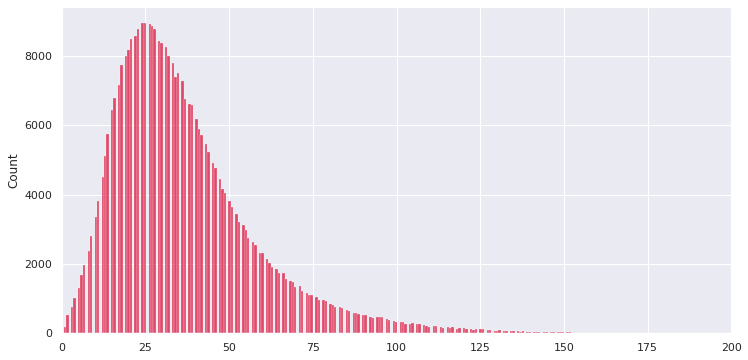

In [8]:
sns.set(style='darkgrid', palette=sns.diverging_palette(145, 400, s=20, l=30,
                                                        n=8))
train_titles = set([row['title'] for _, row in train_games.iterrows()])
reviews_lens = [len(row['body']) for _, row in reviews.iterrows() if 
                row['title'] in train_titles]
fig, ax = plt.subplots(figsize=(12, 6))
plt.xlim(0, 200)
sns.histplot(reviews_lens, ax=ax, color='crimson')
print('Shortest review has:', min(reviews_lens), 'words')
print('Longest review has:', max(reviews_lens), 'words') 
print('Average review length is:', np.mean(reviews_lens), 'words')

Based on those values, we will require all reviews to be of length 50, padding or truncating as needed. We carry out this step and the encoding step (with the aid of the word dicitonary defined above) at once. To organize this data, we use a dictionary with entries of the form title:list of (encoded review, score).


In [9]:
from collections import defaultdict

reviews_dict = defaultdict(list)
max_review_len = 50


def pad_review(review):
  l = len(review)
  if l >= max_review_len:
    return review[:max_review_len]
  else:
    return np.pad(review, (max_review_len-l,0))


for _, row in reviews.iterrows():
  review = [words_dict[word] for word in row['body']]
  review = pad_review(review)
  reviews_dict[row['title']].append((review, row['score']))

# 3. Generating the data

We need to create sets of samples and labels. We will consider two labels, positive (1) and negative (0), assigned based on a threshold on a review's score. To get an idea of what this threshold should be, let's see what the distribution (in percentage) of game metascores is. (Metacritic uses a weighted average of critics reviews in order to produce a game's metascore.)

Mean game metascore is: 70.01138170558205
The standard deviation of game metascores is: 12.179030987278235


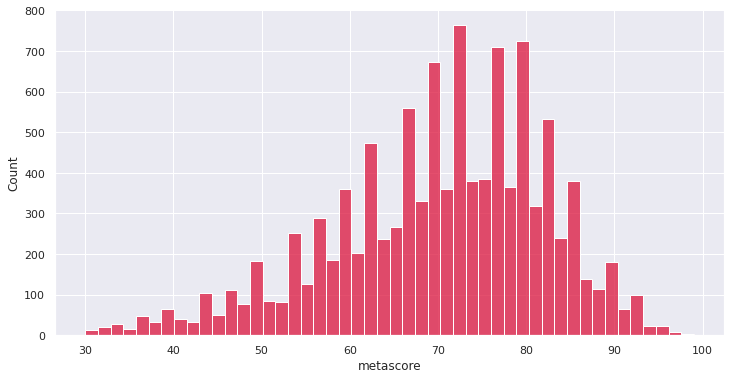

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(train_games['metascore'], color='crimson')
print('Mean game metascore is:', games['metascore'].mean())
print('The standard deviation of game metascores is:', games['metascore'].std())

Given the above values and also the information provided by Metacritic at this [link](https://www.metacritic.com/about-metascores#:~:text=Creating%20our%20proprietary%20Metascores%20is,the%20range%20of%20their%20opinions.), we choose a threshold of 70%. Therefore a review with a score under 70% is considered negative and assigned the label 0, whereas a review with a score above 70% is considered positive and assigned the label 1.

In [ ]:
def create_samples(games_set):
  samples = []
  scores = []
  for _, row in games_set.iterrows():
    for review, score in reviews_dict[row['title']]:
      samples.append(review)
      if score < 70:
        score = 0
      else:
        score = 1
      scores.append(score)
  return samples, scores


# create sets of samples and labels 
train_samples, train_labels = create_samples(train_games)
val_samples, val_labels = create_samples(val_games)
test_samples, test_labels = create_samples(test_games)

Now, it's possible that the dataset is imbalanced. Let's see what the ratio of positive to negative reviews is in the training set and in the validation set.

In [ ]:
train_ratio = train_labels.count(1) / train_labels.count(0)
val_ratio = val_labels.count(1) / val_labels.count(0)
print('Ratio of positive to negative reviews in training set is', train_ratio)
print('Ratio of positive to negative reviews in validation set is', val_ratio)

Ratio of positive to negative reviews in training set is 2.61096826915411
Ratio of positive to negative reviews in validation set is 2.5702276277224945


The dataset is indeed significantly imbalanced. We will have to somehow remedy that later.

Finally, we convert our data to PyTorch tensors.

In [ ]:
import torch
from torch import tensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

emb_matrix = tensor(emb_matrix, device=device, dtype=torch.float)
train_samples = tensor(train_samples, device=device, dtype=torch.long)
train_labels = tensor(train_labels, device=device, dtype=torch.float)
val_samples = tensor(val_samples, device=device, dtype=torch.long)
val_labels = tensor(val_labels, device=device, dtype=torch.float)
test_samples = tensor(test_samples, device=device, dtype=torch.long)
test_labels = tensor(test_labels, device=device, dtype=torch.float)

train_data = TensorDataset(train_samples, train_labels)
val_data = TensorDataset(val_samples, val_labels)
test_data = TensorDataset(test_samples, test_labels)

# 4. Defining and training the model

## 4.1 Defining the model

We will define a deep learning model in PyTorch for the task of classifying reviews as positive or negative. After much tinkering, I've settled on the following architecture. The model consists of a trainable embedding layer with weights initiliazed to the 50d GloVe embedding we loaded earlier, one or more layers of a bidirectional LSTM, two attention heads, a densely connected layer and a sigmoid classifier. The two attention heads serve to attend the two directions of the LSTM. Aggressive dropout is applied to the LSTM layer both at the cell-level and on its output.


In [ ]:
import torch.nn as nn

def create_emb(vocab_size, emb_dim, emb_matrix, trainable=False):
  emb_layer = nn.Embedding(vocab_size, emb_dim)
  emb_layer.load_state_dict({'weight': emb_matrix})
  if not trainable:
    emb_layer.weight.requires_grad = False
  return emb_layer

# implements attention mechanism
class Attention(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.fc1 = nn.Linear(hidden_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 1, bias=False)
    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):
    x = self.fc1(input)
    x = self.tanh(x)
    weights = self.fc2(x)
    weights = self.softmax(weights)
    mul = torch.matmul(input.transpose(dim0=-1, dim1=-2), weights)
    mul = torch.squeeze(mul, dim=-1)
    return mul

# class implementing the architecture of our model
class Sentiment(nn.Module):
  def __init__(self, seq_len, vocab_size, emb_dim, emb_matrix, 
               hidden_dim, output_dim, num_layers, drop_p=0.5):
    super().__init__()
    # save parameters internally
    self.seq_len = seq_len
    self.vocab_size = vocab_size
    self.emb_dim = emb_dim
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # create neural network layers
    self.embedding = create_emb(vocab_size, emb_dim, emb_matrix, trainable=True)
    self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True,
                        dropout=drop_p, bidirectional=True)
    self.dropout = nn.Dropout(drop_p)
    self.attn_past = Attention(hidden_dim)
    self.attn_future = Attention(hidden_dim)
    self.fc1 = nn.Linear(2*hidden_dim, output_dim)
    self.fc2 = nn.Linear(output_dim, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input):
    x = self.embedding(input)
    x, _ = self.lstm(x)
    x = self.dropout(x)
    x_past = x[:, :, :self.hidden_dim]
    x_future = x[:, :, self.hidden_dim:]
    x_past = self.attn_past(x_past)
    x_future = self.attn_future(x_future)
    x = torch.cat((x_past, x_future), dim=-1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    x = torch.squeeze(x, dim=-1)
    return x


vocab_size = len(words_dict)
hidden_dim = 100
output_dim = 25
num_layers = 2
model = Sentiment(max_review_len, vocab_size, emb_dim, emb_matrix, 
                       hidden_dim, output_dim, num_layers, drop_p=0.8)
model.to(device)

Sentiment(
  (embedding): Embedding(109221, 50)
  (lstm): LSTM(50, 100, num_layers=2, batch_first=True, dropout=0.8, bidirectional=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attn_past): Attention(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=1, bias=False)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (attn_future): Attention(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=1, bias=False)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (fc1): Linear(in_features=200, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Next we define functions to calculate metrics of interest: accuracy, precision, recall and F1 score.

In [ ]:
def get_acc(labels, preds):
  acc = np.sum(labels == (preds >= 0.5)) / len(labels)
  return acc


def get_prec(labels, preds, label=1):
  # get number of times class is predicted
  denom = np.sum(preds >= 0.5) if label == 1 else np.sum(preds < 0.5)
  # return invalid value if output is not defined 
  if denom == 0:
    return -1
  # calcualte precision
  prec = np.sum(np.logical_and(labels == (preds >= 0.5), 
                                 labels == label)) / denom
  return prec


def get_recall(labels, preds, label=1):
  # get number of time class appears in labels
  denom = np.sum(labels == label)
  # return invalid value if output is not defined 
  if denom == 0:
    return -1
  # calculate recall
  recall = np.sum(np.logical_and(labels == (preds >= 0.5), 
                                 labels == label)) / denom
  return recall
  
  
def get_f1(labels, preds, label=1):
  # get precision and recall
  prec = get_prec(labels, preds, label=label)
  recall = get_recall(labels, preds, label=label)
  # return invalid value if output is not defined
  if prec == -1 or recall == -1: return -1
  if (prec + recall) == 0: return -1
  # calculate f1
  f1 = 2*(prec*recall) / (prec+recall)
  return f1

## 4.2 Training

Recall that the labels are imbalanced: to account for this, we will monitor a weighted arithmetic average of the F1 scores on the validation dataset, saving the instance of the model that produces the highest value. We train the model for 100 epochs with an Adam optimizer (with betas and epsilon left at PyTorch's defaults), with a batch size of 64 and a learning of 0.001.

In [ ]:
from torch.optim import Adam
from tqdm.notebook import tqdm

batch_size = 64
num_epochs = 100
learning_rate = 0.001

train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, drop_last=True)

optimizer = Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCELoss()

save_path = './best_model'

# training loop
for epoch in range(num_epochs):
  model.train()
  pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch +1}", ascii=True, 
              mininterval=0.3, unit="batches")
  train_losses = []
  train_accs = []
  train_neg_f1s = []
  train_pos_f1s = []

  for batch, (samples, labels) in enumerate(train_loader):

    # Compute prediction and loss
    preds = model(samples)
    loss = loss_func(preds, labels)

    # Backpropagation
    model.zero_grad()
    loss.backward()
    optimizer.step()

    # update progress bar
    pbar.update(1)

    # calculate average loss, accuracy and f1 so far
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    loss = loss.detach().cpu().numpy()
    acc = get_acc(labels, preds)
    neg_f1 = get_f1(labels, preds, label=0)
    pos_f1 = get_f1(labels, preds, label=1)
    train_losses.append(loss)
    train_accs.append(acc)
    if neg_f1 != -1: train_neg_f1s.append(neg_f1)
    if pos_f1 != -1: train_pos_f1s.append(pos_f1)
    train_loss = np.mean(train_losses)
    train_acc = np.mean(train_accs)
    train_neg_f1 = np.mean(train_neg_f1s) if train_neg_f1s != [] else 1
    train_pos_f1 = np.mean(train_pos_f1s) if train_pos_f1s != [] else 1
    train_comb_f1 = (train_ratio*train_neg_f1 + train_pos_f1)/(train_ratio + 1)

    # show metrics on progress bar
    pbar.set_postfix({'train. loss': train_loss, 'train. accuracy': train_acc,
                      'train. comb. f1': train_comb_f1})

  # validate after each epoch
  model.eval()
  val_losses = []
  val_accs = []
  val_neg_f1s = []
  val_pos_f1s = []

  for batch, (samples, labels) in enumerate(val_loader):
    preds = model(samples)
    loss = loss_func(preds, labels)

    # calculate loss, accuracy and f1
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    loss = loss.detach().cpu().numpy()
    acc = get_acc(labels, preds)
    neg_f1 = get_f1(labels, preds, label=0)
    pos_f1 = get_f1(labels, preds, label=1)
    val_losses.append(loss)
    val_accs.append(acc)
    if neg_f1 != -1: val_neg_f1s.append(neg_f1)
    if pos_f1 != -1: val_pos_f1s.append(pos_f1)
  
  # get validation loss, accuracy and f1
  val_loss = np.mean(val_losses)
  val_acc = np.mean(val_accs)
  val_neg_f1 = np.mean(val_neg_f1s)
  val_pos_f1 = np.mean(val_pos_f1s)
  val_comb_f1 = (val_ratio*val_neg_f1 + val_pos_f1)/(val_ratio + 1)

  # show average validation loss and accuracy
  pbar.set_postfix({'train. loss': train_loss, 'train. accuracy': train_acc,
                    'train. comb. f1': train_comb_f1, 'val. loss:': val_loss,
                    'val. accuracy': val_acc, 'val. comb. f1': val_comb_f1})
  
  # save best model with respect to comb. f1, accuracy and loss (in that 
  # order of priority)
  if epoch == 0 or val_comb_f1 > best_comb_f1:
    pass
  elif val_comb_f1 == best_comb_f1 and val_acc > best_acc:
    pass
  elif (val_comb_f1 == best_comb_f1 and val_acc == best_acc and 
  val_loss < best_loss):
    pass
  else:
      continue
  # if execution gets then we save the model
  best_acc = val_acc
  best_loss = val_loss
  best_comb_f1 = val_comb_f1
  print('Saving model to', save_path)
  torch.save(model, save_path)

Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


Saving model to ./best_model


We achieve very high values across the board on both the training and validation data. This makes me optimistic that we have trained a robust model.

# 5. Testing

Let's now test our model on the test data we have held out until now.

In [ ]:
model = torch.load(save_path)
model.eval()
test_losses = []
test_accs = []
test_neg_f1s = []
test_pos_f1s = []

for batch, (samples, labels) in enumerate(test_loader):
  preds = model(samples)
  loss = loss_func(preds, labels)

# calculate loss, accuracy and f1
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  loss = loss.detach().cpu().numpy()
  acc = get_acc(labels, preds)
  neg_f1 = get_f1(labels, preds, label=0)
  pos_f1 = get_f1(labels, preds, label=1)
  test_losses.append(loss)
  test_accs.append(acc)
  if neg_f1 != -1: test_neg_f1s.append(neg_f1)
  if pos_f1 != -1: test_pos_f1s.append(pos_f1)
  
# get validation loss, accuracy and f1
test_loss = np.mean(test_losses)
test_acc = np.mean(test_accs)
test_neg_f1 = np.mean(test_neg_f1s)
test_pos_f1 = np.mean(test_pos_f1s)

print('Test loss is', test_loss)
print('Test accuracy is', test_acc)
print('Test negative f1 is', test_neg_f1)
print('Test positive f1 is', test_pos_f1)

Test loss is 0.5553506
Test accuracy is 0.9522239449097938
Test negative f1 is 0.9022637884919815
Test positive f1 is 0.9614667896229633


The values we get seem very satisfactory, though it is clear we overfitted to the validation data. F1 score for the majority class is higher than for the minority one, which is to be expected even with the precautions we took.

To gauge the strength of these results, we compare them to those of NLTK's built-in sentiment analysis class. Here we will ignore neutral labels, reporting only positive or negative depending on which is assigned the higher probability.

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

rev_words_dict = {v:k for k, v in words_dict.items()}
analyzer = SentimentIntensityAnalyzer()

new_test_samples = []
test_labels = test_labels.detach().cpu().numpy()
for _, row in test_games.iterrows():
  for review, _ in reviews_dict[row['title']]:
    review = ' '.join([rev_words_dict[word] for word in review])
    new_test_samples.append(review)
    
preds = []
for review in new_test_samples:
  pred = analyzer.polarity_scores(review)
  pos, neg = pred['pos'], pred['neg']
  if pos >= neg:
    preds.append(1)
  else:
    preds.append(0)

preds = np.asarray(preds, dtype='float32')
new_test_acc = get_acc(test_labels, preds)
new_test_neg_f1 = get_f1(test_labels, preds, label=0)
new_test_pos_f1 = get_f1(test_labels, preds, label=1)

table = pd.DataFrame(columns=['Accuracy', 'Neg. F1', 'Pos. F1'])
table.loc['Our model'] = [test_acc, test_neg_f1, test_pos_f1]
table.loc['NLTK sentiment analyzer'] = [new_test_acc, new_test_neg_f1, 
                                        new_test_pos_f1]
table

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Accuracy,Neg. F1,Pos. F1
Our model,0.952224,0.902264,0.961467
NLTK sentiment analyzer,0.720653,0.421490,0.815871


Our model handily beats NLTK's unmodified sentiment analysis class. This shows the model lerarned domain-specific features and was able to generalize quite well to unseen data.

# 6. Conclusions

The strong performance of our model suggests that Metacritic's review summarization methods are in fact adequate: the very fact that predicting sentiments of review summaries is learnable to such an extent proves this. I therefore consider that this experiment has answered my questions in the affirmative.

On a seperate note, the model architecture we defined seems to perform very well for being so simple and lightweight. I am curious to find how it performs in other domains of text classification.


